# Projet Machine Learning

nous disposons d'un [dataset](https://www.kaggle.com/datasets/anshtanwar/global-data-on-sustainable-energy) contenant 3649 observations et 21 variables , représentant diverses caractéristiques liées à la consommation énergétique et à la géographie de 176 pays du monde au cours des années 2000 à 2020.
le but de ce projet est de prévoir la quantité d'émission de carbonne produite par personne en tonne métrique en vu d'établir des stratégies de réduction des effets climatiques de l'Homme sur l'environnement .

# Import libraries

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from torch.nn.functional import l1_loss


# Data Cleaning

In [2]:
#we start by importing our dataset
df = pd.read_csv('/content/global-data-on-sustainable-energy.csv')
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [3]:
#we compute the percentage of missing values in our dataset for each variable
round((df.isna().sum()/len(df))*100,2)

Entity                                                               0.00
Year                                                                 0.00
Access to electricity (% of population)                              0.27
Access to clean fuels for cooking                                    4.63
Renewable-electricity-generating-capacity-per-capita                25.51
Financial flows to developing countries (US $)                      57.25
Renewable energy share in the total final energy consumption (%)     5.32
Electricity from fossil fuels (TWh)                                  0.58
Electricity from nuclear (TWh)                                       3.45
Electricity from renewables (TWh)                                    0.58
Low-carbon electricity (% electricity)                               1.15
Primary energy consumption per capita (kWh/person)                   0.00
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          5.67
Value_co2_emissions_kt_by_country     

we realize that we have a lot of missing values in our database so initially we will delete the variables with a high rate of missing values
such as <font color=blue>Financial flows to developing countries (US $)</font>
with <font color=red>57.25%</font> , <font color=blue>Renewable-electricity-generating-capacity-per-capita</font> with <font color=red>25.51%</font>
and <font color=blue>Renewables (% equivalent primary energy)</font> with <font color=red>58.56%</font> and for others variables
we will simply delete the lines where missing values appear

Secondly, we will investigate certain techniques for replacing missing values to replace the missing values of our Database

In [4]:
#let's drop the mentioned columns above
df.drop(columns = ['Renewable-electricity-generating-capacity-per-capita','Financial flows to developing countries (US $)','Renewables (% equivalent primary energy)'],axis=1,inplace = True)

In [5]:
#now we drop the rows where NaN appears
df.dropna(inplace = True)
df.reset_index(drop = True,inplace=True)


In [6]:
#we compute the percentage of missing value again to check that everything is now alright
round((df.isna().sum()/len(df))*100,2)

Entity                                                              0.0
Year                                                                0.0
Access to electricity (% of population)                             0.0
Access to clean fuels for cooking                                   0.0
Renewable energy share in the total final energy consumption (%)    0.0
Electricity from fossil fuels (TWh)                                 0.0
Electricity from nuclear (TWh)                                      0.0
Electricity from renewables (TWh)                                   0.0
Low-carbon electricity (% electricity)                              0.0
Primary energy consumption per capita (kWh/person)                  0.0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0.0
Value_co2_emissions_kt_by_country                                   0.0
gdp_growth                                                          0.0
gdp_per_capita                                                  

# Univariate Statistics

In [7]:
#we get some informations about our data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2868 entries, 0 to 2867
Data columns (total 18 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            2868 non-null   object 
 1   Year                                                              2868 non-null   int64  
 2   Access to electricity (% of population)                           2868 non-null   float64
 3   Access to clean fuels for cooking                                 2868 non-null   float64
 4   Renewable energy share in the total final energy consumption (%)  2868 non-null   float64
 5   Electricity from fossil fuels (TWh)                               2868 non-null   float64
 6   Electricity from nuclear (TWh)                                    2868 non-null   float64
 7   Electricity from renewables (TWh)

we can see that the variable <font color= blue>Density\n(P/Km2) </font> is of type object but it sould be a numerical variable
and the variable Entity is of type Object we'll convert it to categorical variable

we got an error when tried to access the variable <font color= blue>Density\n(P/Km2) </font> by typing
<font color= blue>df['Density\n(P/Km2)'] </font> so we'll use the regular expression to find it real name

In [8]:
#let's find the the name of the colunms Density\n(P/Km2)
density_column = df.columns[df.columns.str.contains(r'Density', flags=re.IGNORECASE)][0]
density_column

'Density\\n(P/Km2)'

In [9]:
#now we rename the variable Density\\n(P/Km2) and we change its type and the type of the variable Entity
df.rename(columns = {'Density\\n(P/Km2)':'Density'},inplace=True)
df['Year'] = df['Year'].astype('category')
df['Entity'] = df['Entity'].astype('category')
df['Density'] = df['Density'].str.replace(',','.').astype('float')

In [10]:
#we get the statistics of our dataset
df.describe()

,Access to electricity (% of population),Access to clean fuels for cooking,Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density,Land Area(Km2),Latitude,Longitude
count,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2.868000e+03,2868.000000,2868.000000,2868.000000,2.868000e+03,2868.000000,2868.000000
mean,76.584630,62.170084,35.802071,76.693556,15.337019,26.603375,39.629403,26082.456843,5.418111,1.688182e+05,3.895326,12577.050921,123.410349,6.581668e+05,18.140402,12.970486
std,31.510371,39.238548,30.024000,374.419806,78.776075,107.640273,34.454884,37097.457254,3.577415,8.180202e+05,4.645613,18730.476190,136.299227,1.705048e+06,24.924975,65.478645
min,1.252269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.110120,1.030000,3.000000e+01,-36.658153,111.927225,1.265000,2.100000e+01,-40.900557,-175.198242
25%,53.237811,22.075000,9.187500,0.290000,0.000000,0.090000,6.091074,2779.966525,3.280000,2.187500e+03,1.770575,1209.802655,25.000000,2.974300e+04,1.650801,-10.940835
50%,97.000000,81.550000,28.790000,2.995000,0.000000,1.680000,35.009718,11922.761000,4.400000,1.042500e+04,3.788166,4168.110171,76.000000,1.319570e+05,17.060816,18.643501
75%,100.000000,100.000000,60.667500,25.787500,0.000000,10.102500,66.879318,31838.556000,6.140000,5.814500e+04,5.957490,14828.344425,152.000000,4.881000e+05,39.399872,43.679291
max,100.000000,100.000000,96.040000,5098.220000,809.410000,2014.570000,100.000010,262585.700000,32.570000,1.070722e+07,63.379875,123514.196700,668.000000,9.984670e+06,64.963051,178.065032


In [11]:
#we take only numerical columns
df1 = df.select_dtypes(include = [np.number])

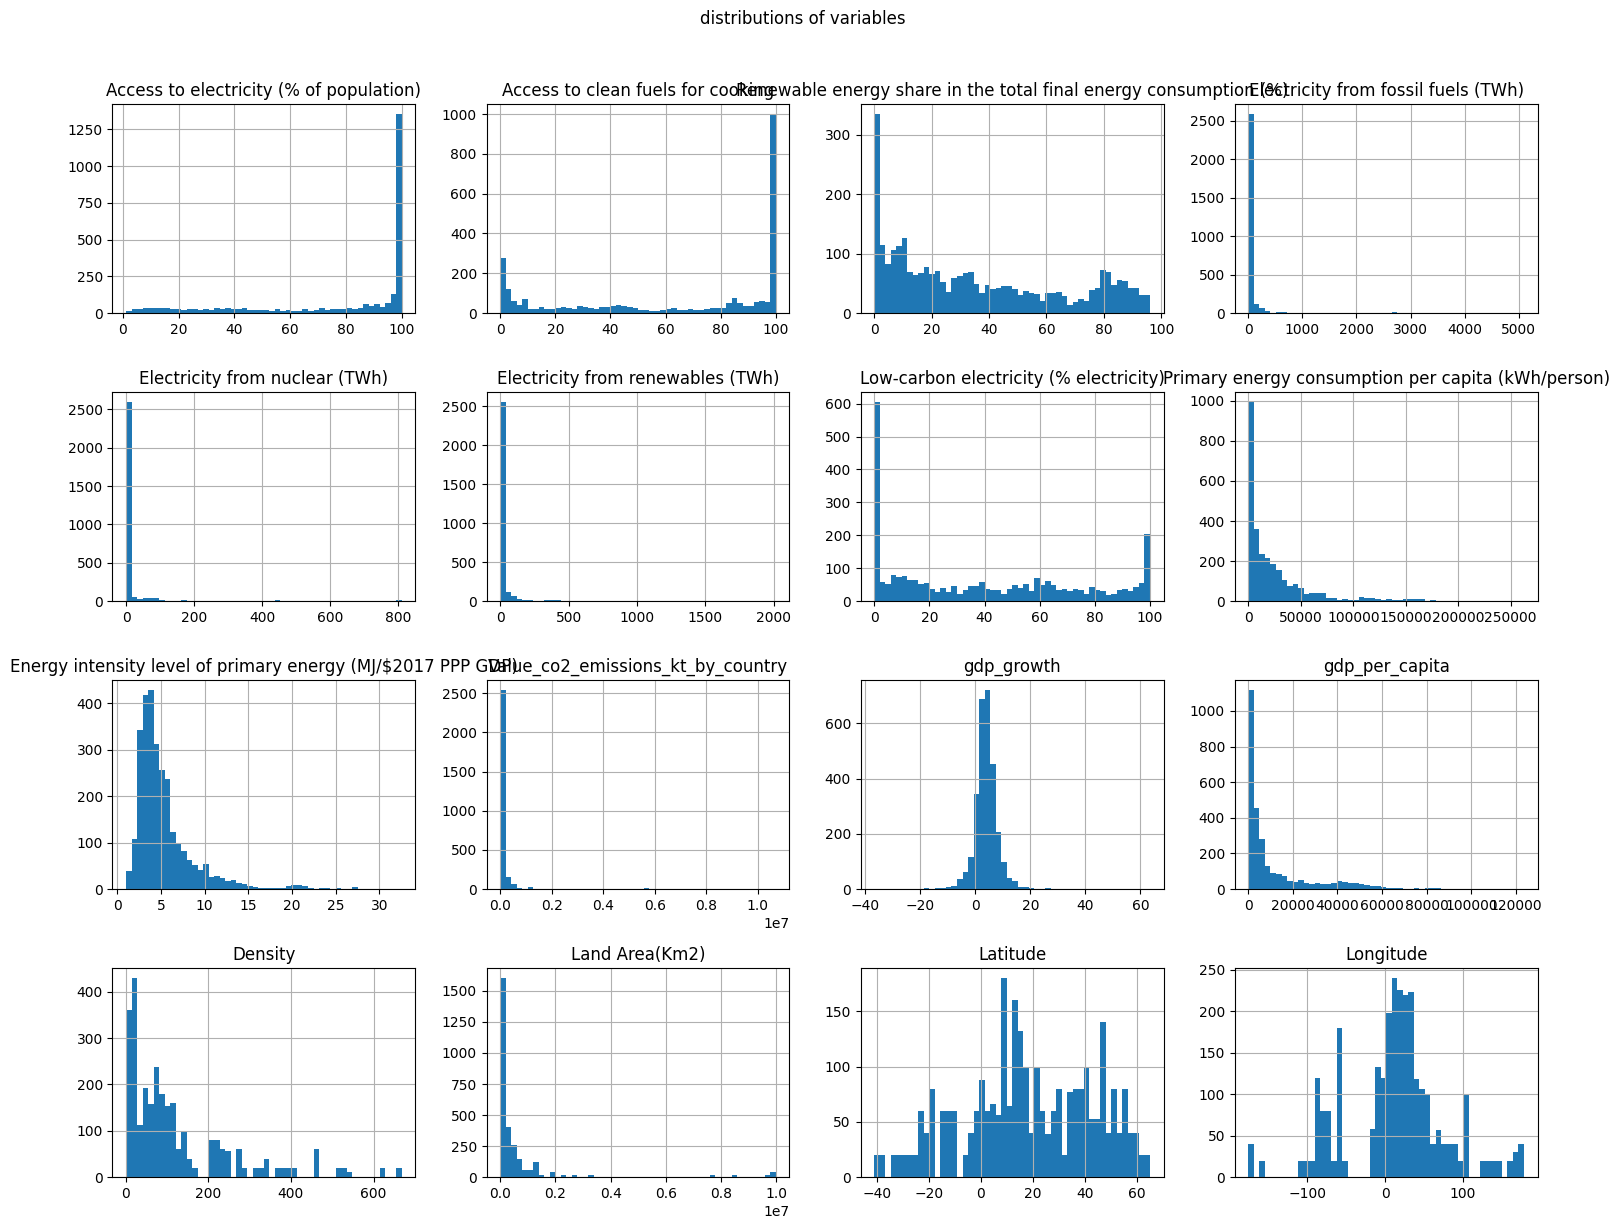

In [12]:
#features distribution of our variables
df1.hist(bins = 50,figsize=(15,12))
plt.suptitle('distributions of variables',x=0.5,y=1.02,ha='center',fontsize='large')
plt.tight_layout()
plt.show()

In [13]:
def show(columns,figsize):
    df1[columns].boxplot(figsize=figsize)
    plt.suptitle('Boxplot',x=0.5,y=1.02,ha='center',fontsize='large')
    #plt.tight_layout()
    plt.show()

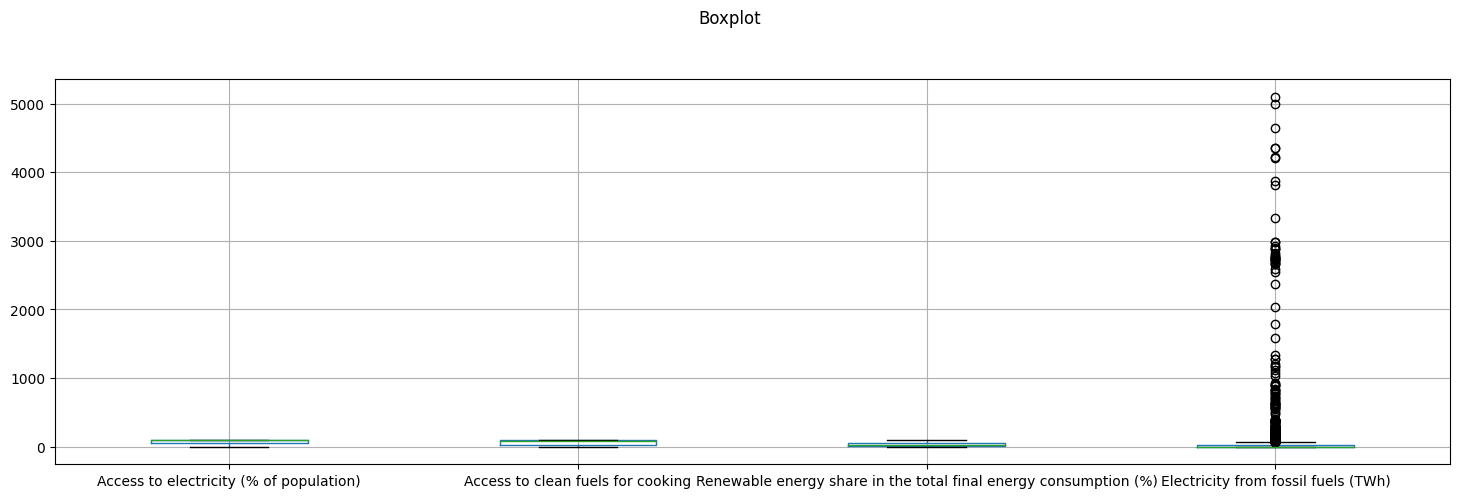

In [14]:
show(df1.columns[:4],(18,5))

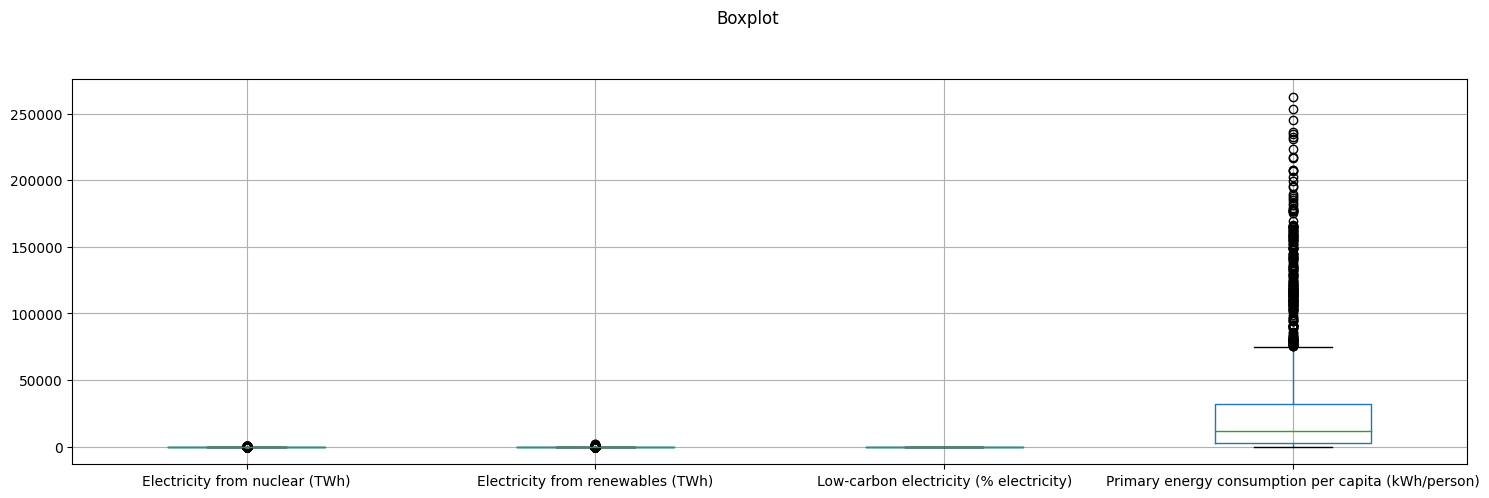

In [ ]:
show(df1.columns[4:8],(18,5))

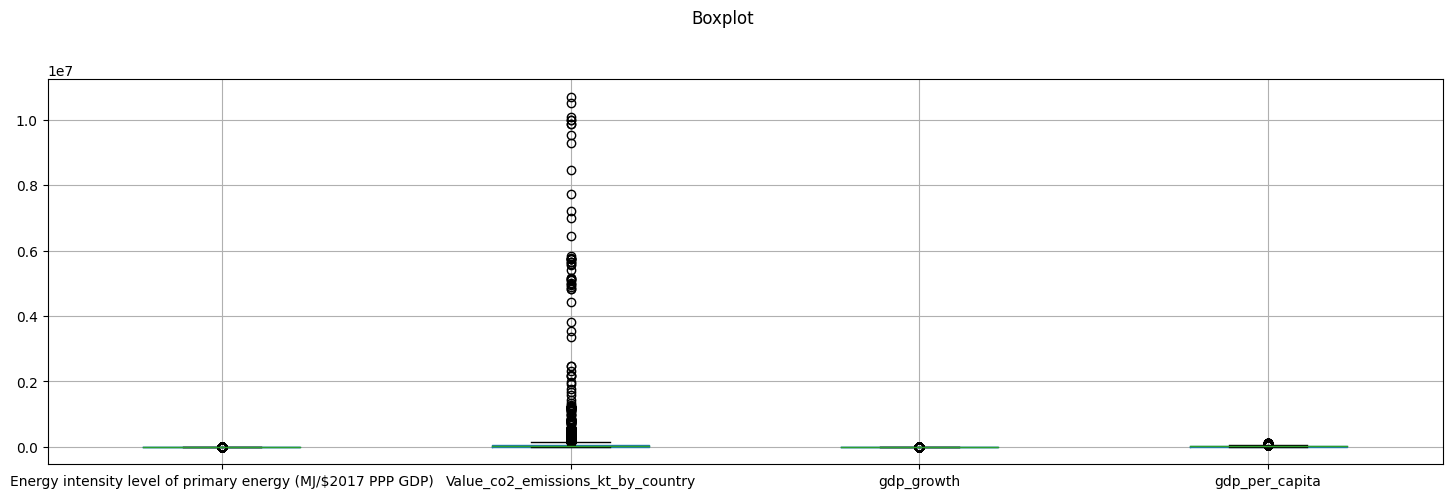

In [15]:
show(df1.columns[8:12],(18,5))

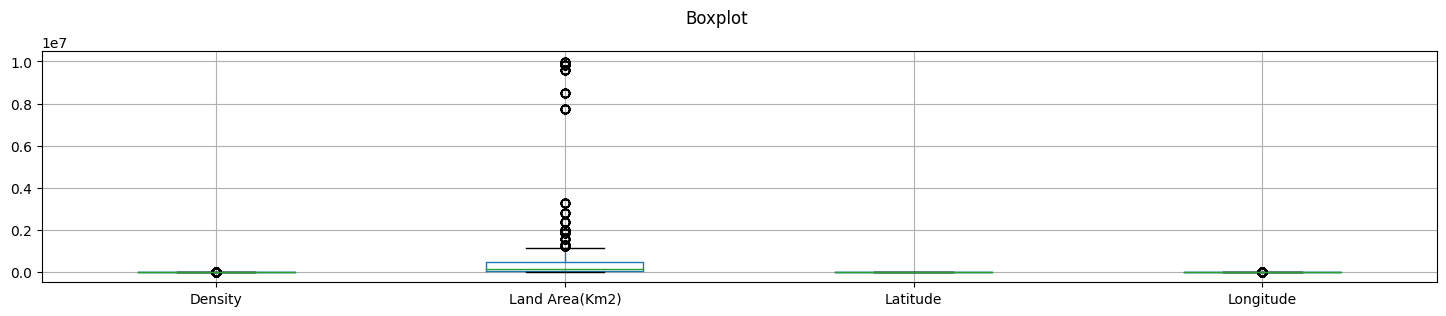

In [16]:
show(df1.columns[12:16],(18,3))

In [ ]:
#nomber of outliers
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1
is_outliers = (df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))
is_outliers.sum()

Access to electricity (% of population)                               0
Access to clean fuels for cooking                                     0
Renewable energy share in the total final energy consumption (%)      0
Electricity from fossil fuels (TWh)                                 385
Electricity from nuclear (TWh)                                      489
Electricity from renewables (TWh)                                   444
Low-carbon electricity (% electricity)                                0
Primary energy consumption per capita (kWh/person)                  233
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         220
Value_co2_emissions_kt_by_country                                   409
gdp_growth                                                          161
gdp_per_capita                                                      381
Density                                                             250
Land Area(Km2)                                                  

In [ ]:
topics = df.groupby('Entity',observed=True)['Value_co2_emissions_kt_by_country'].sum().to_frame()[:30]

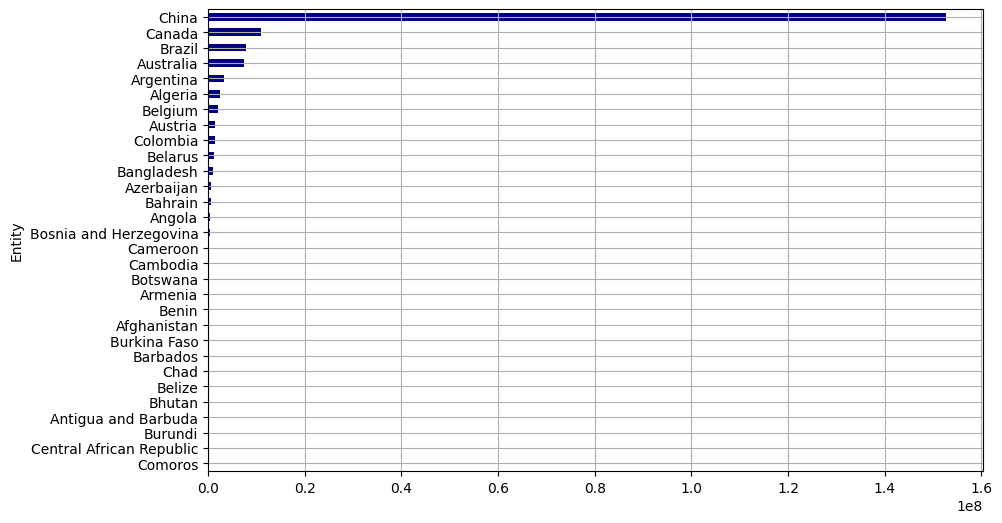

In [ ]:
#visualisons les 30 pays les plus emeteurs de co2 dans le monde
topics = df.groupby('Entity',observed=True)['Value_co2_emissions_kt_by_country'].sum().to_frame()[:30]
topics.sort_values(by='Value_co2_emissions_kt_by_country',ascending=True).plot(kind='barh',colormap='jet',legend=False,figsize=(10,6))
plt.grid(True)
plt.show()

# Bivariate Statistics

In [18]:
#correlation in our dataset
corr = df1.corr()
corr

,Access to electricity (% of population),Access to clean fuels for cooking,Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density,Land Area(Km2),Latitude,Longitude
Access to electricity (% of population),1.000000,0.873346,-0.784041,0.134122,0.141985,0.158707,-0.159906,0.463193,-0.261321,0.133546,-0.106350,0.443714,0.059883,0.077406,0.449867,-0.133779
Access to clean fuels for cooking,0.873346,1.000000,-0.794656,0.101704,0.172232,0.135423,-0.136655,0.561424,-0.194590,0.093662,-0.149866,0.554457,0.017739,0.082761,0.453261,-0.126025
Renewable energy share in the total final energy consumption (%),-0.784041,-0.794656,1.000000,-0.153083,-0.159468,-0.094132,0.474051,-0.438326,0.238766,-0.144988,0.085547,-0.369993,-0.088635,-0.067660,-0.349024,0.044408
Electricity from fossil fuels (TWh),0.134122,0.101704,-0.153083,1.000000,0.644911,0.840460,-0.076464,0.105615,0.031369,0.989846,0.021873,0.131331,0.047997,0.636273,0.118993,0.039014
Electricity from nuclear (TWh),0.141985,0.172232,-0.159468,0.644911,1.000000,0.484125,0.062260,0.183278,-0.014443,0.597728,-0.070091,0.265571,-0.005950,0.470568,0.184573,-0.095510
Electricity from renewables (TWh),0.158707,0.135423,-0.094132,0.840460,0.484125,1.000000,0.083562,0.130822,0.007493,0.857375,-0.001884,0.171251,-0.017494,0.732365,0.123903,-0.024848
Low-carbon electricity (% electricity),-0.159906,-0.136655,0.474051,-0.076464,0.062260,0.083562,1.000000,-0.125828,0.055379,-0.060200,-0.026760,0.027079,-0.165220,0.044976,-0.071617,-0.055684
Primary energy consumption per capita (kWh/person),0.463193,0.561424,-0.438326,0.105615,0.183278,0.130822,-0.125828,1.000000,0.138585,0.095448,-0.043154,0.711630,0.001348,0.116577,0.348802,0.048921
Energy intensity level of primary energy (MJ/$2017 PPP GDP),-0.261321,-0.194590,0.238766,0.031369,-0.014443,0.007493,0.055379,0.138585,1.000000,0.044390,0.113404,-0.163810,-0.092977,0.063227,-0.012146,0.120148
Value_co2_emissions_kt_by_country,0.133546,0.093662,-0.144988,0.989846,0.597728,0.857375,-0.060200,0.095448,0.044390,1.000000,0.034117,0.112554,0.038627,0.657828,0.120536,0.041251


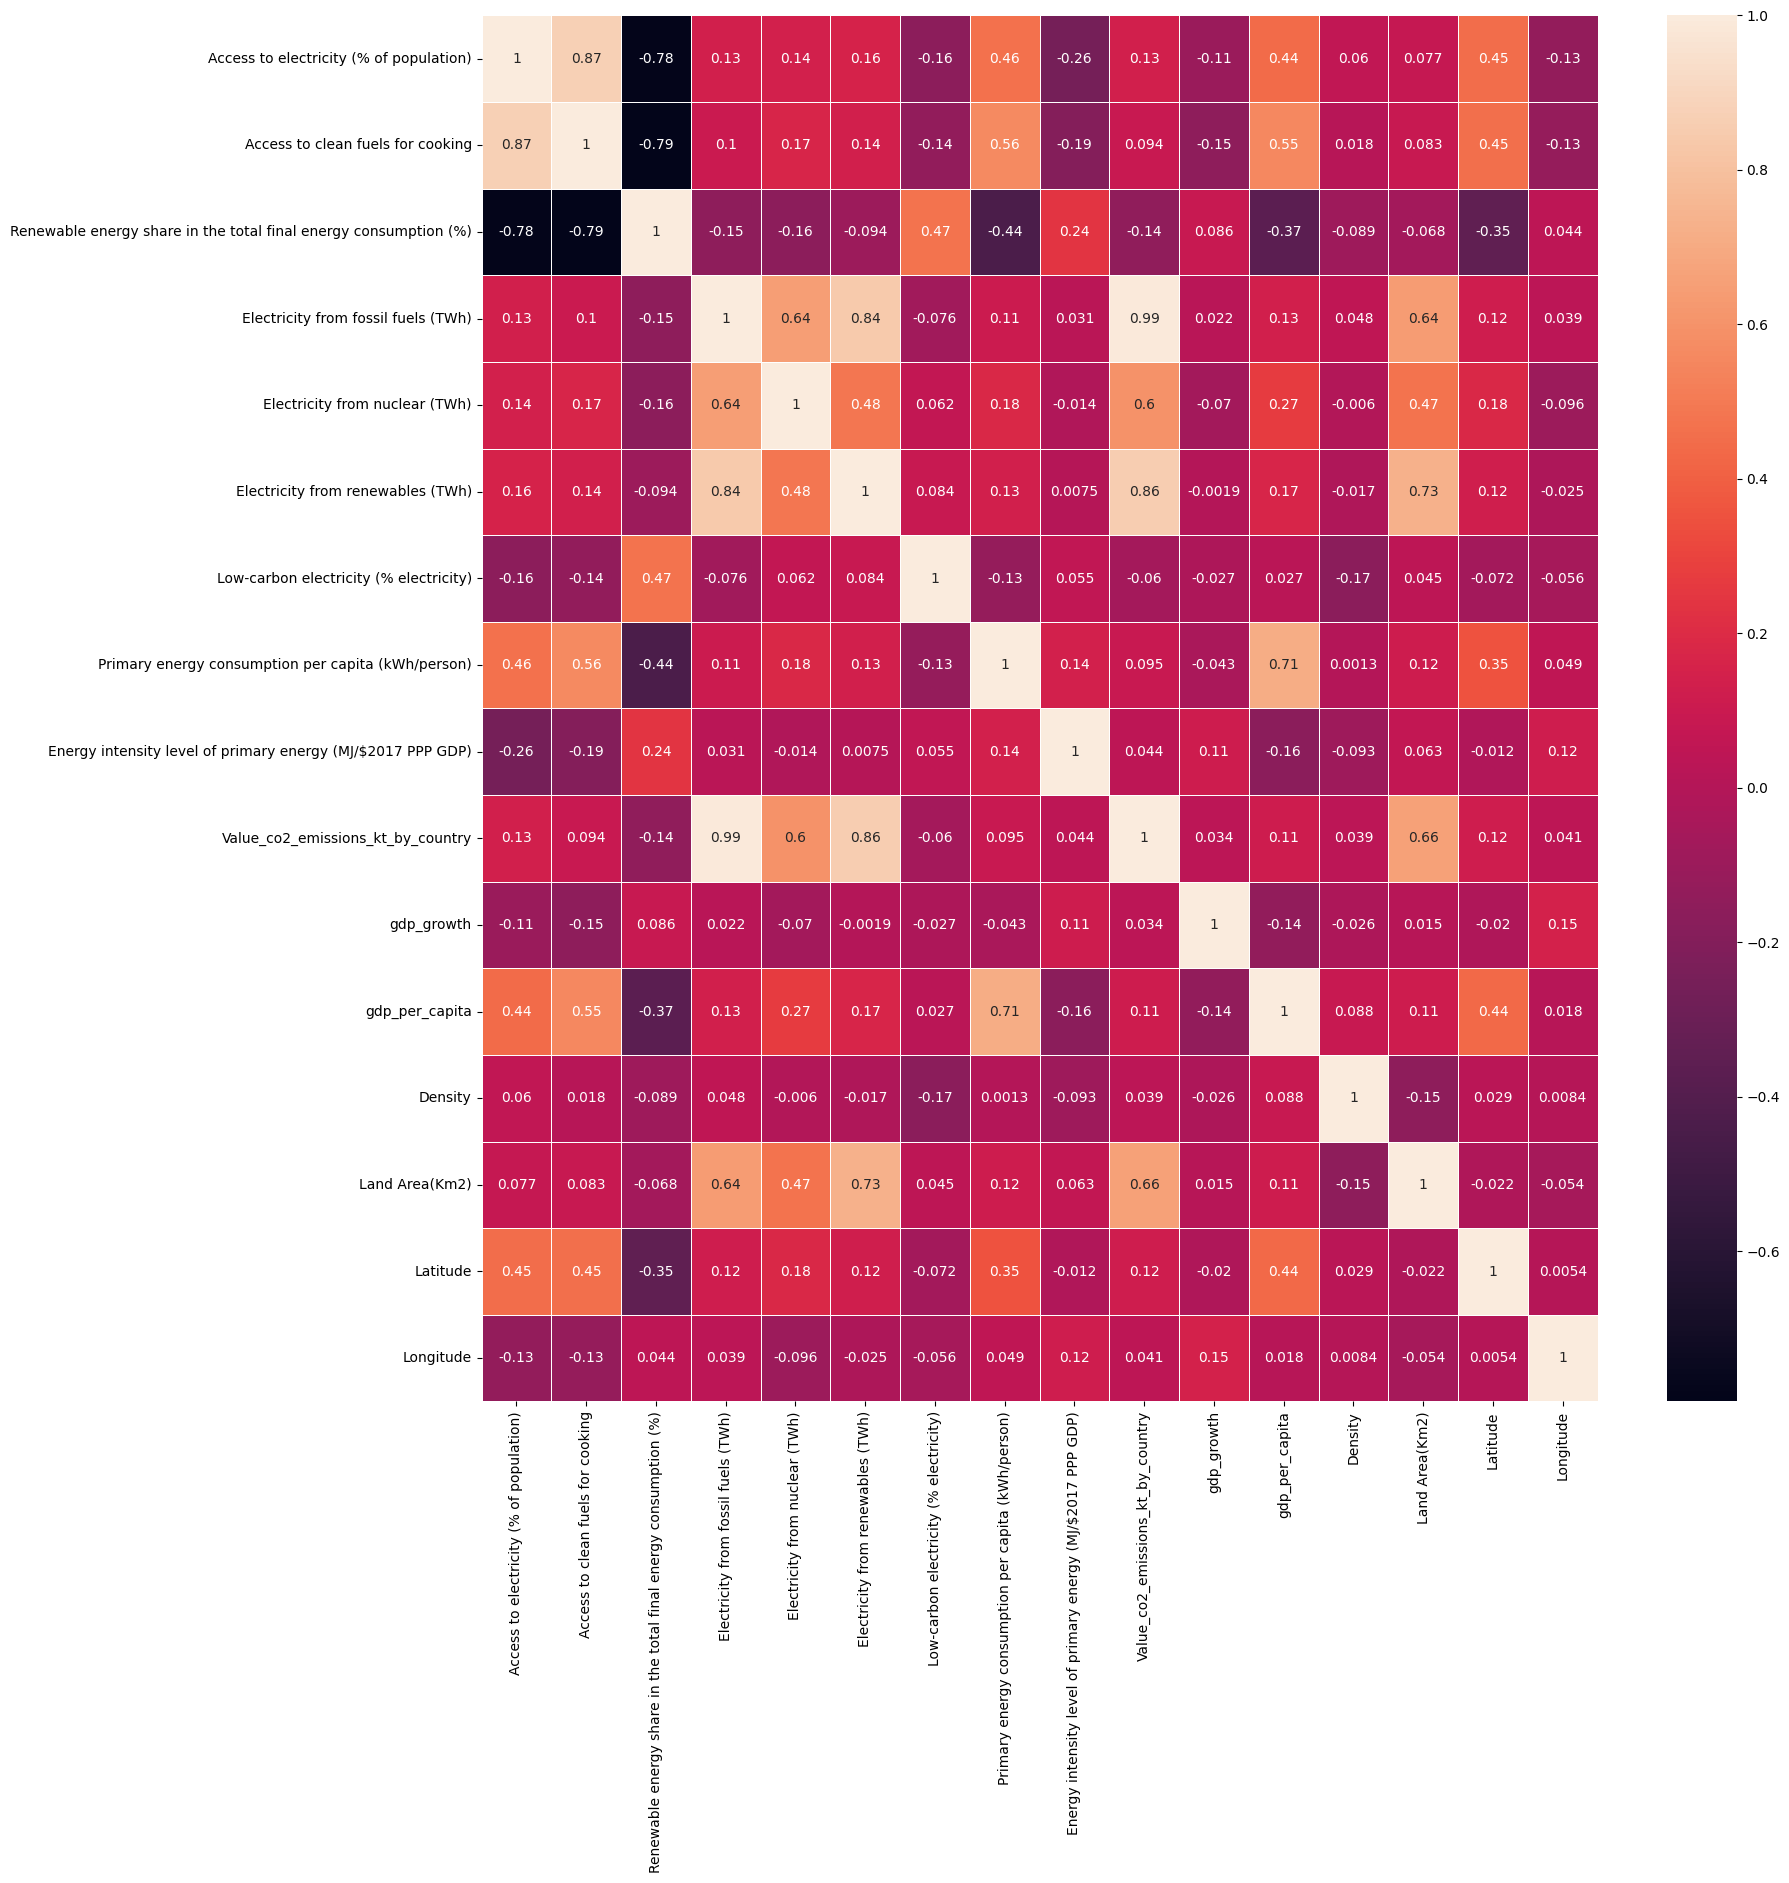

In [19]:
#we create a heatmap to visualize the dependencies between features
plt.figure(figsize=(18,18))
sns.heatmap(df1.corr(), annot=True ,linecolor='white',linewidths=0.4)
plt.show()

In [20]:
#we start by scaling our data since they're not on the same scale
n = df1.shape[0]
p = df1.shape[1]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df1)

In [21]:
#we determine the number of important factor
pca = PCA()
coord = pca.fit_transform(scaled_data)
print(pca.explained_variance_ratio_)

[0.2810174  0.20029218 0.08584406 0.08280081 0.06484781 0.05673968
 0.05317854 0.04536772 0.04004269 0.03298774 0.02229592 0.01185169
 0.00851395 0.00748922 0.00628915 0.00044142]


In [22]:
sum = np.cumsum(pca.explained_variance_ratio_*100)
sum

array([ 28.10174025,  48.130958  ,  56.71536363,  64.9954451 ,
        71.48022628,  77.15419383,  82.47204779,  87.00882015,
        91.0130896 ,  94.31186374,  96.54145616,  97.72662538,
        98.57802052,  99.32694279,  99.95585824, 100.        ])

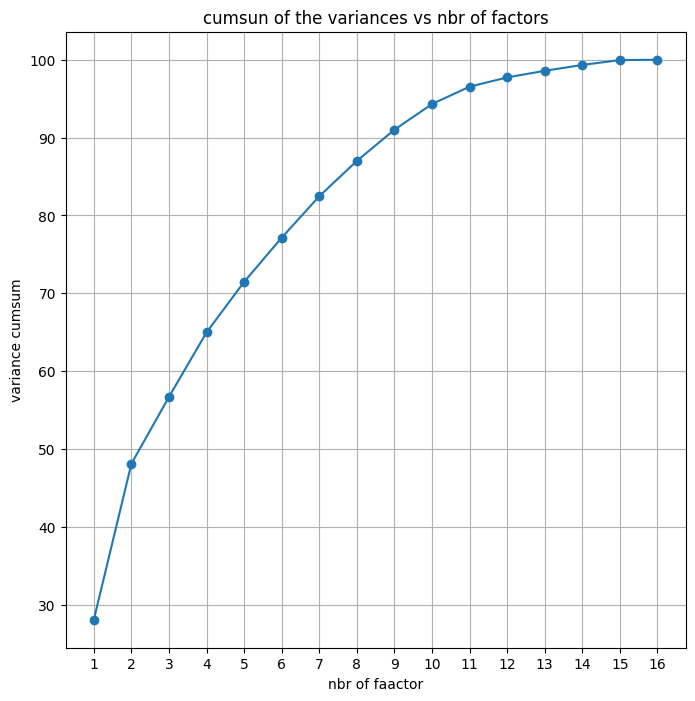

In [23]:
# Plot the scree plot
fig,axs = plt.subplots(figsize=(8,8))
axs.set_xticks(np.arange(18))
axs.plot(np.arange(1,p+1),sum,marker='o')
plt.title('cumsun of the variances vs nbr of factors')
plt.xlabel('nbr of faactor')
plt.ylabel('variance cumsum')
plt.grid('on')
plt.show()


In [243]:
#we extract the columns
categorical_columns = df.select_dtypes(include='category').columns
numerical_columns = list(df.select_dtypes(include='number').columns)
numerical_columns.pop(9)

'Value_co2_emissions_kt_by_country'

In [244]:
# Initialize the StandardScaler
scaler = StandardScaler()
scaler1 = StandardScaler()
# Fit and transform the data using the scaler
c = scaler1.fit_transform(df['Value_co2_emissions_kt_by_country'].values.reshape(-1,1))
df_target_scaled = pd.DataFrame(c,columns = ['Value_co2_emissions_kt_by_country'])
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_columns]), columns=numerical_columns)
# One-hot encode the 'Category' column
df_encoded = pd.get_dummies(df[categorical_columns])

# Concatenate the one-hot encoded DataFrame with the scaled numerical DataFrame
df_final = pd.concat([df_encoded, df_scaled,df_target_scaled], axis=1)

In [245]:
df_final.head()

,Entity_Afghanistan,Entity_Algeria,Entity_Angola,Entity_Antigua and Barbuda,Entity_Argentina,Entity_Armenia,Entity_Australia,Entity_Austria,Entity_Azerbaijan,Entity_Bahrain,...,Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),gdp_growth,gdp_per_capita,Density,Land Area(Km2),Latitude,Longitude,Value_co2_emissions_kt_by_country
0,1,0,0,0,0,0,0,0,0,0,...,0.795146,-0.697002,-1.123384,1.062898,-0.661410,-0.46531,-0.003482,0.633961,0.836135,-0.204918
1,1,0,0,0,0,0,0,0,0,0,...,0.676131,-0.697696,-1.179300,-0.534190,-0.660305,-0.46531,-0.003482,0.633961,0.836135,-0.205151
2,1,0,0,0,0,0,0,0,0,0,...,0.691211,-0.696406,-1.120588,1.579053,-0.658668,-0.46531,-0.003482,0.633961,0.836135,-0.204515
3,1,0,0,0,0,0,0,0,0,0,...,1.061314,-0.694995,-1.095426,0.314777,-0.657509,-0.46531,-0.003482,0.633961,0.836135,-0.204258
4,1,0,0,0,0,0,0,0,0,0,...,1.141343,-0.693650,-1.087039,2.138087,-0.652385,-0.46531,-0.003482,0.633961,0.836135,-0.204246


In [248]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, features, target):
        self.X = data[features].values
        self.y = data[target].values
        self.len = len(data)

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return self.len
#we construct our NN architecture
class RegressionNN(nn.Module):
    def __init__(self,input_size):
        super(RegressionNN,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32,256)
        self.fc3 = nn.Linear(256,1)
    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
def cal_rmse(predictions,targets):
  mse = nn.MSELoss()
  rmse = torch.sqrt(mse(predictions,targets))
  return rmse.item()

In [249]:
# Split the data into training and testing sets
df_train, df_test = train_test_split(df_final, test_size=0.2, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [250]:
# Hyperparameters
input_size = df_final.shape[-1]-1  # Number of input features
n_epochs = 150  # Adjust the number of epochs as needed
#we initialize the parameter for the kfold cross validation
n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True,random_state=42)
#lists to store trainig and validation losses for each fold
val_losses = []
train_losses = []

In [251]:
target = ['Value_co2_emissions_kt_by_country']
features = df_final.columns.difference(target)

In [252]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [253]:
#training loop with 5-fold validation
for fold,(train_indices,val_indices) in enumerate(kf.split(df_train)):
    x_train,x_val = df_train.iloc[train_indices],df_train.iloc[val_indices]

    train_dataset = CustomDataset(x_train,features,target)
    val_dataset = CustomDataset(x_val,features,target)
    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)

    #instantiate the model, the optimizer and the loss function
    model = RegressionNN(input_size).to(device)
    loss_fn = nn.MSELoss().to(device)
    optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.0005)

    # Lists to store losses during training
    epoch_train_losses = []

    for epochs in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for train_input,train_target in train_loader:
            train_input,train_target = train_input.to(device),train_target.to(device)
            train_preds = model(train_input)
            train_loss = loss_fn(train_target,train_preds)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            epoch_loss += train_loss.item()
        # Average training loss for the epoch
        epoch_train_losses.append(epoch_loss / len(train_loader))
    #validation on the current fold
    fold_val=0.0
    model.eval()
    with torch.no_grad():
        for val_input, val_target in val_loader:
          val_input,val_target = val_input.to(device),val_target.to(device)
          val_pred = model(val_input)
          val_loss = loss_fn(val_target,val_pred)
          fold_val += val_loss.item()


    # Print losses for the current fold
    print(f'Fold [{fold + 1}/{n_splits}], Training Loss: {epoch_train_losses[-1]:.4f}, Validation Loss: {val_loss.item():.4f}')


    # Store losses for plotting
    train_losses.append(epoch_train_losses)
    val_losses.append(fold_val)




Fold [1/5], Training Loss: 0.0013, Validation Loss: 0.0015
Fold [2/5], Training Loss: 0.0013, Validation Loss: 0.0001
Fold [3/5], Training Loss: 0.0011, Validation Loss: 0.0039
Fold [4/5], Training Loss: 0.0012, Validation Loss: 0.0000
Fold [5/5], Training Loss: 0.0016, Validation Loss: 0.0036


In [193]:
test_dataset = CustomDataset(df_test,features,target)
test_loader = DataLoader(dataset = test_dataset,batch_size=4,shuffle=True)

In [254]:
all_truth = []
all_preds = []

model.eval()
with torch.no_grad():
  for test_input, test_label in test_loader:
    test_input,test_label = test_input.to(device),test_label.to(device)
    y_pred = model(test_input)

    all_preds.extend(y_pred)
    all_truth.extend(test_label)

# Convert predictions and targets to PyTorch tensors
predictions = torch.tensor(all_preds)
targets = torch.tensor(all_truth)


#we compute the RMSE
rmse = loss_fn(targets,predictions)
R2 = r2_score(targets,predictions)
mae = l1_loss(targets,predictions)
print(f'the RMSE is : {rmse},the R2 is {R2} on the test dataset and the MAE is {mae}')




the RMSE is : 0.0023978129029273987,the R2 is 0.9975295337899208 on the test dataset and the MAE is 0.02529330737888813


In [266]:
torch.save(model.state_dict(), 'model2.pth')

In [262]:
#we inverse transform the targets and the predictions
gt_co2 = scaler1.inverse_transform(targets.numpy().reshape(-1,1))
pred_co2 = scaler1.inverse_transform(predictions.numpy().reshape(-1,1))

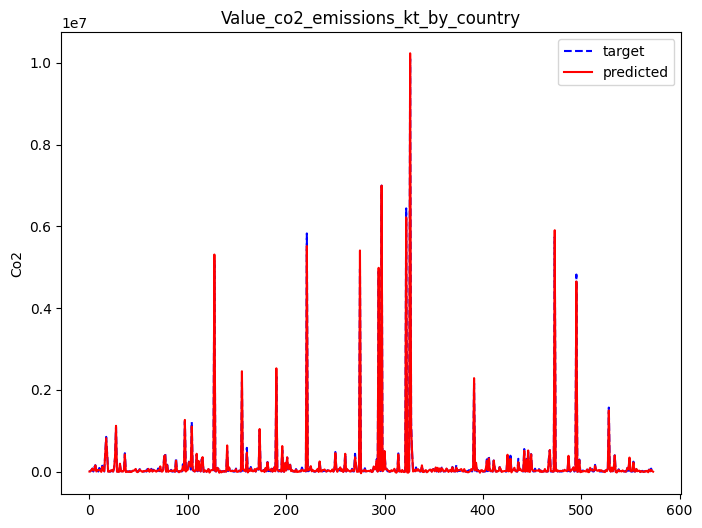

In [267]:
# Créer la figure et les axes
plt.figure(figsize=(8, 6))

# Tracer la première courbe
plt.plot(gt_co2, label='target', color='blue', linestyle='--')

# Tracer la deuxième courbe
plt.plot(pred_co2, label='predicted', color='red', linestyle='-')

# Ajouter un titre et des étiquettes d'axe
plt.title('Value_co2_emissions_kt_by_country')
#plt.xlabel('')
plt.ylabel('Co2')

# Ajouter une légende
plt.legend()
plt.savefig('plot_ml2.jpg', bbox_inches='tight')

# Afficher la figure
plt.show()

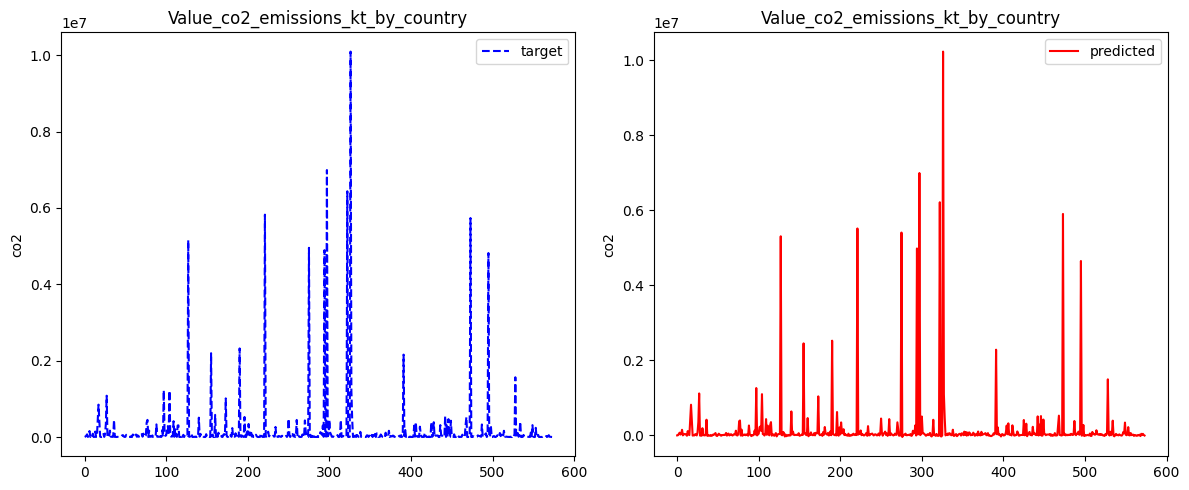

In [268]:
# Create a figure with subplots
plt.figure(figsize=(12, 5))

# Plot the first curve in the first subplot
plt.subplot(1, 2, 1)
plt.plot(gt_co2, label='target', color='blue', linestyle='--')
plt.title('Value_co2_emissions_kt_by_country')
plt.ylabel('co2')
plt.legend()

# Plot the second curve in the second subplot
plt.subplot(1, 2, 2)
plt.plot(pred_co2, label='predicted', color='red', linestyle='-')
plt.title('Value_co2_emissions_kt_by_country')
plt.ylabel('co2')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('plot_ml3.jpg')
# Show the plot
plt.show()